In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'year_node_shallow'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=0
Data directory: d:\DSS5104\data
experiment: year_node_shallow_2025.04.25_0754


In [ ]:
data = lib.Dataset("adult", random_state=999, quantile_transform=True, quantile_noise=1e-3)
in_features = data.X_train.shape[1]

mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid = map(normalize, [data.y_train, data.y_valid])

print("mean = %.5f, std = %.5f" % (mu, std))

Seeding: 999
binary classification
(30162, 14) (30162,)
(15060, 14) (15060,)
mean = 0.24892, std = 0.43239


In [3]:
model = nn.Sequential(
    lib.DenseBlock(in_features, 2048, num_layers=1, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:1000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [4]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [ ]:
task_type = 'regression' 
d_out = 1

if task_type == "classification":
    loss_fn = F.binary_cross_entropy_with_logits if d_out == 1 else F.cross_entropy
else:
    loss_fn = F.mse_loss 

trainer = lib.Trainer(
    model=model, loss_function=loss_fn,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 500
report_frequency = 100

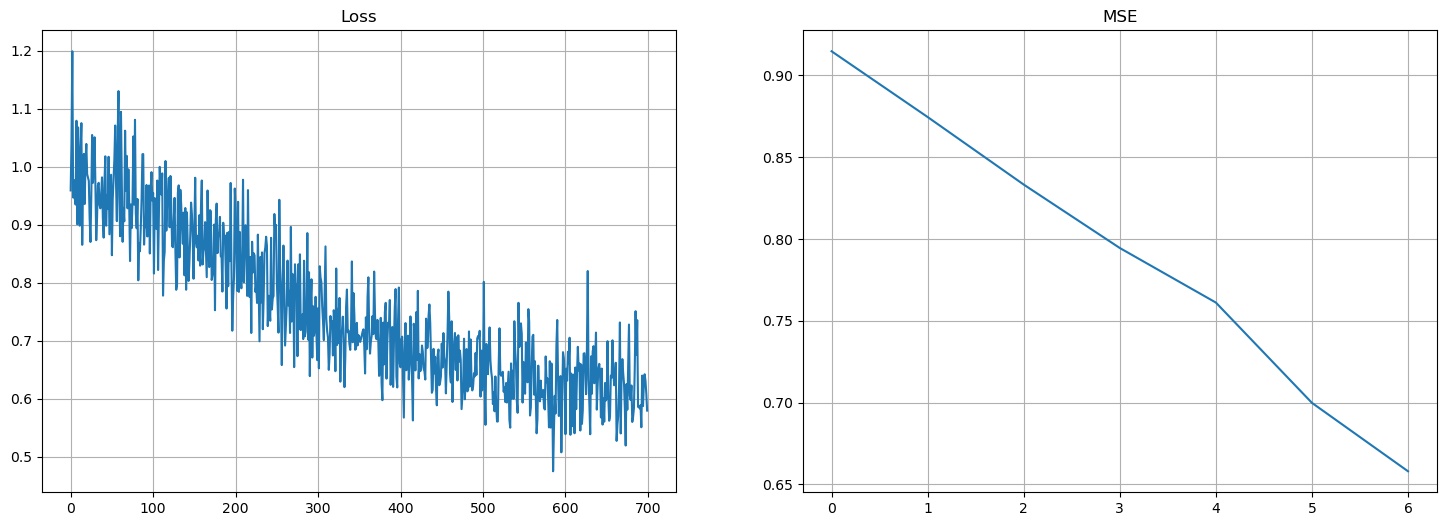

Loss 0.57933
Val MSE: 0.65798
Saved logs/year_node_shallow_2025.04.25_0754\checkpoint_temp_800.pth
Loaded logs/year_node_shallow_2025.04.25_0754\checkpoint_avg.pth


KeyboardInterrupt: 

In [9]:
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=256, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
        
        clean_loss = [loss.item() if torch.is_tensor(loss) else float(loss) for loss in loss_history]
        clean_mse = [mse.item() if torch.is_tensor(mse) else float(mse) for mse in mse_history]

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(clean_loss)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(clean_mse)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [8]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(data.X_test, data.y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/year_node_shallow_2019.08.27_17:32/checkpoint_best_mse.pth
Best step:  53100
Test MSE: 0.64902


In [9]:
mse * std ** 2

77.51119264257828